In [1]:
import sys
sys.path.append("../")
import os, os.path as osp
import numpy as np
from collections import namedtuple
import torch
import torch.nn as nn
import torch.functional as F
import cv2
import matplotlib.pyplot as plt


import mcubes
from IPython.core.debugger import set_trace

/home/ayush/projects/nerf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device='cuda'

# Nerf Model with Fourier Features

This is the paper with all the details: [Paper](https://arxiv.org/pdf/2006.10739.pdf) <br>
The basic idea is that we can map the input to a fourier feature set. <br>
And this mapping transforms the Neural Tangent Kernel (NTK) into a **stationary (shift invariant)** kernel. <br>

**Directly from the paper:**

This mapping enables tuning the NTK’s spectrum by modifying the frequency vectors bj , thereby <br>
controlling the range of frequencies that can be learned by the corresponding MLP. We show that the <br>
simple strategy of setting aj = 1 and randomly sampling bj from an isotropic distribution achieves <br>
good performance, and that the scale (standard deviation) of this distribution matters much more than <br>
its specific shape. We train MLPs with this Fourier feature input mapping across a range of tasks <br>
relevant to the computer vision and graphics communities. As highlighted in Figure 1, our proposed <br>
mapping dramatically improves the performance of coordinate-based MLPs

In [4]:
class FourierNerf(nn.Module):
    
    def __init__(self, NF_feats=256, B_scale=6.05, hidden_dim=128, device='cpu'):
        super(FourierNerf, self).__init__()
        self.block = nn.Sequential( nn.Linear(NF_feats * 2, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, 4),
                                    ).to(device)

        self.NF_feats = NF_feats
        self.hidden_dim = hidden_dim
        self.device=device
        self.B = torch.randn((3, NF_feats), device=device) * 2 * torch.pi * B_scale
        
        for _, param in self.block.named_parameters():
            if isinstance(param, nn.Linear):
                nn.init.xavier_uniform_(param.weight)
                if param.bias is not None:
                    nn.init.zeros_(param.bias)
    
    def positional_encoding(self, xyz):
        Tsin = torch.sin(xyz @ self.B)
        Tcos = torch.cos(xyz @ self.B)
        return torch.cat([Tcos, Tsin], axis=-1)
        
    
    def forward(self, xyz_p):
        """
        xyz_p: ray points
        xyz_d: ray_directions
        """
        if xyz_p.device != self.device:
            xyz_p = xyz_p.to(self.device)
        B = xyz_p.shape[0] # Batch size
        
        ## getting positional embeddings
        F_embed = self.positional_encoding(xyz_p)  # BS, NF_feat
        # set_trace()
        
        # run the Neural net
        out = self.block(F_embed) # BS, 4
        colors = torch.sigmoid(out[:, :3])
        density = torch.relu(out[:, -1:])
        return colors, density
    
    
    def intersect(self, xyz_p):
        return self.forward(xyz_p)
        
        
NF_feats=256
B_scale=6.05
hidden_dim = 128
Fnerf = FourierNerf(NF_feats=NF_feats, B_scale=B_scale, hidden_dim=hidden_dim, device=device)

# Rendering

In [5]:
from src.utils.render import render, accumulated_transmittance, find_t0_for_image

In [6]:
def render_with_perturbation(model: nn.Module,
           rays_o: np.ndarray,
           rays_d: np.ndarray,
           tn: float,
           tf: float,
           num_bins=100,
           device='cpu',
           directional_input=True,
           white_bgr=True):
    """
    Assigns color values to each ray
    :param model: A model to represent the 3D shape
    :param rays_o: Origin of rays coming from camera
    :param rays_d: Direction of rays coming from camera
    :param tn: initial query time
    :param tf: final query time. We will integreate bw tn, tf
    :param num_bins: the num of bins to divide this query window in
    :param device: {cuda, cpu}
    :param white_bckgr: if the image has a white background
    :return:
    """

    num_points = rays_o.shape[0]
    if isinstance(rays_o, np.ndarray):
        rays_o = torch.from_numpy(rays_o).float().to(device=device)
    if isinstance(rays_d, np.ndarray):
        rays_d = torch.from_numpy(rays_d).float().to(device=device)
    t = torch.linspace(tn, tf, num_bins).to(device=device).expand(rays_o.shape[0], num_bins)  # Npts, nbins
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(rays_o.shape[0], 1)), -1)

    r = rays_o.unsqueeze(1) + t.unsqueeze(2) * rays_d.unsqueeze(1)  # [batch_size, nb_bins, 3]
    if directional_input:
        colors, density = model.intersect(r.reshape(-1, 3),
                                          rays_d.expand(num_bins, num_points, 3).transpose(0, 1).reshape(-1, 3))
    else:
        colors, density = model.intersect(r.reshape(-1, 3))

    density = density.reshape(num_points, num_bins)  # density: Npts, Nbins
    colors = colors.reshape(num_points, num_bins, 3)  # colors: Npts , Nbins, 3
    alpha = 1. - torch.exp(- density * delta)  # Npts, Nbins
    weights = accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)

    if white_bgr:
        c = (weights * colors).sum(1)  # [nb_rays, 3]
        weight_sum = weights.sum(-1).sum(-1)  # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights * colors).sum(1)  # [nb_rays, 3]
    return c


def batchify_image_and_render(model: nn.Module,
                              rays_o: np.ndarray,
                              rays_d: np.ndarray,
                              tn: float,
                              tf: float,
                              num_bins: int=100,
                              reduction_factor:int=128,
                              directional_input=True,
                              device='cpu',
                              white_bgr=True) -> np.ndarray:
    """

    :param model: A model to represent the 3D shape
    :param rays_o: Origin of rays coming from camera
    :param rays_d: Direction of rays coming from camera
    :param tn: initial query time
    :param tf: final query time. We will integreate bw tn, tf
    :param reduction_factor: Divides the total points by this factor
    :param num_bins: the num of bins to divide this query window in
    :param device: {cuda, cpu}
    :param white_bckgr: if the image has a white background
    :return:
    """
    npts = rays_o.shape[0]
    assert npts % reduction_factor == 0
    batch_o = rays_o.reshape(-1, npts//reduction_factor, 3)
    batch_d = rays_d.reshape(-1, npts//reduction_factor, 3)
    Ax = np.zeros_like(batch_o)
    for i in range(batch_o.shape[0]):
        Ax[i] = render(model,
                       batch_o[i],
                       batch_d[i],
                       tn=tn,
                       tf=tf,
                       num_bins=num_bins,
                       device=device,
                       directional_input=directional_input,
                       white_bgr=white_bgr).detach().cpu()
    return Ax.reshape(-1, 3)

# Generating experiment Session

In [7]:
Session = namedtuple('Session', ['sess_dir', 't_started'])

def generate_new_session(root, obj=None):
    from datetime import datetime
    dt = datetime.now()
    dt_str = dt.strftime("%Y-%m-%d %H:%M:%S") # Convert datetime to a string
    if obj is None:
        obj = ""
    sess_dir = osp.join(root, f"exp-{obj}-{dt_str}")
    if not osp.exists(sess_dir):
        os.makedirs(sess_dir, exist_ok=True)
    session = Session(sess_dir, dt)
    return session

def save_model(sess, model, epoch):
    modelpath = osp.join(sess.sess_dir, f"epoch-{epoch}")
    torch.save(model.cpu(), modelpath)

# Training on Lego 100x100

## Load the Lego Dataset

In [8]:
from src.utils.dataset.lego_dataset import create_rays

obj = "lego"
H = W = 100
root = f"../assets/{obj}"

focal = np.load(osp.join(root, "focal.npy"))
poses = np.load(osp.join(root, "poses.npy"))
imgs = np.load(osp.join(root, "images.npy"))

print(imgs.shape, poses.shape)
o, d, imgt = [], [], []
N = len(imgs)
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], focal)
    o.append(o_)
    d.append(d_)
    imgt.append(imgs[i].reshape(-1, 3))
    
o = np.array(o)
d = np.array(d)
imgt = np.array(imgt)
print("Shapes: ", o.shape, d.shape, imgt.shape)
dataset = np.concatenate([o.reshape(-1, 3), d.reshape(-1, 3), imgt.reshape(-1, 3)], axis=1).astype(np.float32)
dataset.shape, dataset.dtype

(106, 100, 100, 3) (106, 4, 4)
Shapes:  (106, 10000, 3) (106, 10000, 3) (106, 10000, 3)


((1060000, 9), dtype('float32'))

## Training Loop

### Dataloader

In [9]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataloader_train = DataLoader(torch.from_numpy(dataset).to(device=device), batch_size=batch_size, shuffle=True)

### Define Hyper-parameters

In [13]:

obj = "lego"

## Model Hyperparams
NF_feats=256
B_scale=6.05
hidden_dim = 128

## Rendering params
tn = 2.
tf = 6.
num_bins = 192
directional_input = False
white_bgr = True

## Training
num_epochs= 5000
warmup_epochs = 1
lr = 5e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### Optimization

In [14]:

loss_history = []

model = FourierNerf(NF_feats=NF_feats, B_scale=B_scale, hidden_dim=hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[10, 15, 20], gamma=0.5)


## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/fourier_nerf", obj)


################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse


def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for tid in test_ids:
            o_, d_ = create_rays(imgs[tid], poses[tid], focal)
            im  = imgs[tid]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=16,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {tid}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            imdir = osp.join(session.sess_dir, f"epoch_{epoch}")
            if not osp.exists(imdir):
                os.makedirs(imdir)
            impath = osp.join(imdir, f"epoch-{epoch}--image-{tid}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))

####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_train): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, 
                    directional_input=directional_input, device=device,
                   white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader_train)}")
    # scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    


--------------------------------------

Starting main process


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.31it/s]


Epoch: 0: avg_loss: 0.05034468320475237
Test IDs: 13       | PSNR:  14.291 | MSE : 0.037
Test IDs: 79       | PSNR:  16.576 | MSE : 0.022
Test IDs: 99       | PSNR:  14.157 | MSE : 0.038
Test IDs: 14       | PSNR:  15.325 | MSE : 0.029
Test IDs: 74       | PSNR:  14.447 | MSE : 0.036


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.00it/s]


Epoch: 1: avg_loss: 0.0250811135651666
Test IDs: 13       | PSNR:  16.635 | MSE : 0.022
Test IDs: 79       | PSNR:  17.672 | MSE : 0.017
Test IDs: 99       | PSNR:  15.470 | MSE : 0.028
Test IDs: 14       | PSNR:  16.710 | MSE : 0.021
Test IDs: 74       | PSNR:  15.871 | MSE : 0.026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.37it/s]


Epoch: 2: avg_loss: 0.01992040646844993
Test IDs: 13       | PSNR:  17.099 | MSE : 0.020
Test IDs: 79       | PSNR:  18.296 | MSE : 0.015
Test IDs: 99       | PSNR:  16.674 | MSE : 0.022
Test IDs: 14       | PSNR:  17.363 | MSE : 0.018
Test IDs: 74       | PSNR:  16.545 | MSE : 0.022


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.29it/s]


Epoch: 3: avg_loss: 0.017363478234541173
Test IDs: 13       | PSNR:  17.798 | MSE : 0.017
Test IDs: 79       | PSNR:  18.821 | MSE : 0.013
Test IDs: 99       | PSNR:  17.377 | MSE : 0.018
Test IDs: 14       | PSNR:  18.241 | MSE : 0.015
Test IDs: 74       | PSNR:  17.180 | MSE : 0.019


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 30.66it/s]


Epoch: 4: avg_loss: 0.01570732578272036
Test IDs: 13       | PSNR:  18.505 | MSE : 0.014
Test IDs: 79       | PSNR:  19.336 | MSE : 0.012
Test IDs: 99       | PSNR:  17.579 | MSE : 0.017
Test IDs: 14       | PSNR:  18.096 | MSE : 0.016
Test IDs: 74       | PSNR:  17.569 | MSE : 0.018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 30.86it/s]


Epoch: 5: avg_loss: 0.014470993199576282
Test IDs: 13       | PSNR:  18.629 | MSE : 0.014
Test IDs: 79       | PSNR:  19.337 | MSE : 0.012
Test IDs: 99       | PSNR:  17.792 | MSE : 0.017
Test IDs: 14       | PSNR:  18.915 | MSE : 0.013
Test IDs: 74       | PSNR:  17.975 | MSE : 0.016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.49it/s]


Epoch: 6: avg_loss: 0.013438230429858717
Test IDs: 13       | PSNR:  18.668 | MSE : 0.014
Test IDs: 79       | PSNR:  19.359 | MSE : 0.012
Test IDs: 99       | PSNR:  17.726 | MSE : 0.017
Test IDs: 14       | PSNR:  18.401 | MSE : 0.014
Test IDs: 74       | PSNR:  17.337 | MSE : 0.018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.79it/s]


Epoch: 7: avg_loss: 0.01259265043844674
Test IDs: 13       | PSNR:  19.279 | MSE : 0.012
Test IDs: 79       | PSNR:  20.345 | MSE : 0.009
Test IDs: 99       | PSNR:  18.817 | MSE : 0.013
Test IDs: 14       | PSNR:  18.934 | MSE : 0.013
Test IDs: 74       | PSNR:  18.547 | MSE : 0.014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.69it/s]


Epoch: 8: avg_loss: 0.011791304836200701
Test IDs: 13       | PSNR:  18.575 | MSE : 0.014
Test IDs: 79       | PSNR:  19.932 | MSE : 0.010
Test IDs: 99       | PSNR:  19.450 | MSE : 0.011
Test IDs: 14       | PSNR:  19.775 | MSE : 0.011
Test IDs: 74       | PSNR:  18.534 | MSE : 0.014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.74it/s]


Epoch: 9: avg_loss: 0.011244812439120299
Test IDs: 13       | PSNR:  19.404 | MSE : 0.011
Test IDs: 79       | PSNR:  20.429 | MSE : 0.009
Test IDs: 99       | PSNR:  19.086 | MSE : 0.012
Test IDs: 14       | PSNR:  19.116 | MSE : 0.012
Test IDs: 74       | PSNR:  17.857 | MSE : 0.016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.72it/s]


Epoch: 10: avg_loss: 0.010635034295345538
Test IDs: 13       | PSNR:  19.631 | MSE : 0.011
Test IDs: 79       | PSNR:  20.716 | MSE : 0.008
Test IDs: 99       | PSNR:  20.085 | MSE : 0.010
Test IDs: 14       | PSNR:  20.480 | MSE : 0.009
Test IDs: 74       | PSNR:  19.379 | MSE : 0.012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 32.00it/s]


Epoch: 11: avg_loss: 0.01013526927030728
Test IDs: 13       | PSNR:  19.678 | MSE : 0.011
Test IDs: 79       | PSNR:  20.791 | MSE : 0.008
Test IDs: 99       | PSNR:  20.223 | MSE : 0.010
Test IDs: 14       | PSNR:  20.717 | MSE : 0.008
Test IDs: 74       | PSNR:  19.331 | MSE : 0.012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.85it/s]


Epoch: 12: avg_loss: 0.009738680524985274
Test IDs: 13       | PSNR:  19.838 | MSE : 0.010
Test IDs: 79       | PSNR:  21.231 | MSE : 0.008
Test IDs: 99       | PSNR:  20.513 | MSE : 0.009
Test IDs: 14       | PSNR:  21.005 | MSE : 0.008
Test IDs: 74       | PSNR:  19.431 | MSE : 0.011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.75it/s]


Epoch: 13: avg_loss: 0.009428308934196255
Test IDs: 13       | PSNR:  19.924 | MSE : 0.010
Test IDs: 79       | PSNR:  21.483 | MSE : 0.007
Test IDs: 99       | PSNR:  20.719 | MSE : 0.008
Test IDs: 14       | PSNR:  20.741 | MSE : 0.008
Test IDs: 74       | PSNR:  19.603 | MSE : 0.011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.79it/s]


Epoch: 14: avg_loss: 0.009046540277359223
Test IDs: 13       | PSNR:  20.313 | MSE : 0.009
Test IDs: 79       | PSNR:  21.650 | MSE : 0.007
Test IDs: 99       | PSNR:  20.611 | MSE : 0.009
Test IDs: 14       | PSNR:  20.957 | MSE : 0.008
Test IDs: 74       | PSNR:  19.840 | MSE : 0.010


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.74it/s]


Epoch: 15: avg_loss: 0.00878997623397246
Test IDs: 13       | PSNR:  20.200 | MSE : 0.010
Test IDs: 79       | PSNR:  21.511 | MSE : 0.007
Test IDs: 99       | PSNR:  20.884 | MSE : 0.008
Test IDs: 14       | PSNR:  21.703 | MSE : 0.007
Test IDs: 74       | PSNR:  19.787 | MSE : 0.011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.74it/s]


Epoch: 16: avg_loss: 0.00852412501175647
Test IDs: 13       | PSNR:  19.867 | MSE : 0.010
Test IDs: 79       | PSNR:  21.645 | MSE : 0.007
Test IDs: 99       | PSNR:  21.631 | MSE : 0.007
Test IDs: 14       | PSNR:  21.958 | MSE : 0.006
Test IDs: 74       | PSNR:  19.634 | MSE : 0.011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.69it/s]


Epoch: 17: avg_loss: 0.008380536798614304
Test IDs: 13       | PSNR:  20.352 | MSE : 0.009
Test IDs: 79       | PSNR:  21.949 | MSE : 0.006
Test IDs: 99       | PSNR:  21.530 | MSE : 0.007
Test IDs: 14       | PSNR:  21.805 | MSE : 0.007
Test IDs: 74       | PSNR:  19.824 | MSE : 0.010


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.65it/s]


Epoch: 18: avg_loss: 0.008254076054402443
Test IDs: 13       | PSNR:  20.371 | MSE : 0.009
Test IDs: 79       | PSNR:  21.975 | MSE : 0.006
Test IDs: 99       | PSNR:  21.384 | MSE : 0.007
Test IDs: 14       | PSNR:  21.991 | MSE : 0.006
Test IDs: 74       | PSNR:  20.429 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.61it/s]


Epoch: 19: avg_loss: 0.008132827756782583
Test IDs: 13       | PSNR:  20.091 | MSE : 0.010
Test IDs: 79       | PSNR:  21.851 | MSE : 0.007
Test IDs: 99       | PSNR:  21.643 | MSE : 0.007
Test IDs: 14       | PSNR:  21.885 | MSE : 0.006
Test IDs: 74       | PSNR:  19.931 | MSE : 0.010


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.64it/s]


Epoch: 20: avg_loss: 0.008063612916618298
Test IDs: 13       | PSNR:  20.625 | MSE : 0.009
Test IDs: 79       | PSNR:  22.132 | MSE : 0.006
Test IDs: 99       | PSNR:  21.425 | MSE : 0.007
Test IDs: 14       | PSNR:  21.562 | MSE : 0.007
Test IDs: 74       | PSNR:  20.242 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.78it/s]


Epoch: 21: avg_loss: 0.0077564308143842926
Test IDs: 13       | PSNR:  20.615 | MSE : 0.009
Test IDs: 79       | PSNR:  22.194 | MSE : 0.006
Test IDs: 99       | PSNR:  21.832 | MSE : 0.007
Test IDs: 14       | PSNR:  22.047 | MSE : 0.006
Test IDs: 74       | PSNR:  20.387 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.81it/s]


Epoch: 22: avg_loss: 0.007609734273044587
Test IDs: 13       | PSNR:  20.195 | MSE : 0.010
Test IDs: 79       | PSNR:  22.009 | MSE : 0.006
Test IDs: 99       | PSNR:  21.981 | MSE : 0.006
Test IDs: 14       | PSNR:  22.067 | MSE : 0.006
Test IDs: 74       | PSNR:  20.152 | MSE : 0.010


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 30.90it/s]


Epoch: 23: avg_loss: 0.0076713360114289185
Test IDs: 13       | PSNR:  20.575 | MSE : 0.009
Test IDs: 79       | PSNR:  22.077 | MSE : 0.006
Test IDs: 99       | PSNR:  21.881 | MSE : 0.006
Test IDs: 14       | PSNR:  22.250 | MSE : 0.006
Test IDs: 74       | PSNR:  20.292 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.35it/s]


Epoch: 24: avg_loss: 0.007374176671045282
Test IDs: 13       | PSNR:  20.935 | MSE : 0.008
Test IDs: 79       | PSNR:  22.385 | MSE : 0.006
Test IDs: 99       | PSNR:  21.937 | MSE : 0.006
Test IDs: 14       | PSNR:  22.136 | MSE : 0.006
Test IDs: 74       | PSNR:  20.425 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.85it/s]


Epoch: 25: avg_loss: 0.007284395496494004
Test IDs: 13       | PSNR:  20.987 | MSE : 0.008
Test IDs: 79       | PSNR:  22.443 | MSE : 0.006
Test IDs: 99       | PSNR:  22.141 | MSE : 0.006
Test IDs: 14       | PSNR:  22.140 | MSE : 0.006
Test IDs: 74       | PSNR:  20.646 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.23it/s]


Epoch: 26: avg_loss: 0.007219708554310055
Test IDs: 13       | PSNR:  19.942 | MSE : 0.010
Test IDs: 79       | PSNR:  21.830 | MSE : 0.007
Test IDs: 99       | PSNR:  21.946 | MSE : 0.006
Test IDs: 14       | PSNR:  22.170 | MSE : 0.006
Test IDs: 74       | PSNR:  20.399 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.02it/s]


Epoch: 27: avg_loss: 0.0071680206566344246
Test IDs: 13       | PSNR:  21.080 | MSE : 0.008
Test IDs: 79       | PSNR:  22.379 | MSE : 0.006
Test IDs: 99       | PSNR:  22.037 | MSE : 0.006
Test IDs: 14       | PSNR:  21.988 | MSE : 0.006
Test IDs: 74       | PSNR:  20.371 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.75it/s]


Epoch: 28: avg_loss: 0.007060700439143221
Test IDs: 13       | PSNR:  20.670 | MSE : 0.009
Test IDs: 79       | PSNR:  22.556 | MSE : 0.006
Test IDs: 99       | PSNR:  22.437 | MSE : 0.006
Test IDs: 14       | PSNR:  22.487 | MSE : 0.006
Test IDs: 74       | PSNR:  20.627 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:32<00:00, 31.57it/s]


Epoch: 29: avg_loss: 0.006978812777620657
Test IDs: 13       | PSNR:  20.974 | MSE : 0.008
Test IDs: 79       | PSNR:  22.646 | MSE : 0.005
Test IDs: 99       | PSNR:  22.231 | MSE : 0.006
Test IDs: 14       | PSNR:  22.273 | MSE : 0.006
Test IDs: 74       | PSNR:  20.586 | MSE : 0.009


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:34<00:00, 30.37it/s]


Epoch: 30: avg_loss: 0.006935396725689438
Test IDs: 13       | PSNR:  20.742 | MSE : 0.008
Test IDs: 79       | PSNR:  22.688 | MSE : 0.005
Test IDs: 99       | PSNR:  22.361 | MSE : 0.006
Test IDs: 14       | PSNR:  22.571 | MSE : 0.006
Test IDs: 74       | PSNR:  20.799 | MSE : 0.008


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:33<00:00, 31.05it/s]


Epoch: 31: avg_loss: 0.006862250614271258
Test IDs: 13       | PSNR:  21.070 | MSE : 0.008
Test IDs: 79       | PSNR:  22.498 | MSE : 0.006
Test IDs: 99       | PSNR:  21.877 | MSE : 0.006
Test IDs: 14       | PSNR:  22.311 | MSE : 0.006
Test IDs: 74       | PSNR:  20.607 | MSE : 0.009


 20%|████████████████████▎                                                                                | 208/1036 [00:06<00:26, 31.47it/s]


KeyboardInterrupt: 

# Train FoxDataset

## Load the fox dataset

In [8]:
root = "../assets/fox"

In [9]:
from src.utils.dataset.fox_dataset import make_file_lists, parse_data, create_rays, FoxDataset



fimgs, fposes, fintrinsics= make_file_lists(root, 'train')
imgs, poses, intrinsics = parse_data(fimgs, fposes, fintrinsics)

# small batch experiment
N = len(imgs)
o, d = [], []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
    o.append(o_)
    d.append(d_)
o = np.array(o)
d = np.array(d)
o.shape, d.shape

(90, 400, 400, 3) (90, 4, 4) (90, 4, 4)


((90, 160000, 3), (90, 160000, 3))

## Training Loop

### Initialize Dataloader

In [10]:
from src.utils.dataset.fox_dataset import FoxDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataset_warmup = FoxDataset(imgs, poses, intrinsics, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = FoxDataset(imgs, poses, intrinsics, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Center region: Width 100: 300,  Height: 100: 300
Final shapes: O:(3600000, 3), D:(3600000, 3), Imgs:(3600000, 3)
Final concatenated shape: torch.Size([3600000, 9])
Final shapes: O:(90, 160000, 3), D:(90, 160000, 3), Imgs:(90, 400, 400, 3)
Final concatenated shape: torch.Size([14400000, 9])


### Define Hyperparameters

In [11]:



obj = "fox"

## Model Hyperparams
NF_feats=256
B_scale=6.05
hidden_dim = 128

### RENDERING HYPERARAMS

tn = 8.
tf = 12.
num_bins = 100
directional_input=False
white_bgr=True

###  TRAINING
num_epochs= 30
warmup_epochs = 1
lr = 1e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

In [12]:
N, test_ids

(90, array([48, 40, 40, 42, 63]))

### Optimization

Test IDs: 48       | PSNR:  11.898 | MSE : 0.065
Test IDs: 40       | PSNR:  13.363 | MSE : 0.046
Test IDs: 40       | PSNR:  13.363 | MSE : 0.046
Test IDs: 42       | PSNR:  12.571 | MSE : 0.055
Test IDs: 63       | PSNR:  12.349 | MSE : 0.058
Starting warm-up


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3516/3516 [01:07<00:00, 52.36it/s]


Epoch: 1: avg_loss: 0.024331723256086967
Test IDs: 48       | PSNR:  25.385 | MSE : 0.003
Test IDs: 40       | PSNR:  26.343 | MSE : 0.002
Test IDs: 40       | PSNR:  26.343 | MSE : 0.002
Test IDs: 42       | PSNR:  24.340 | MSE : 0.004
Test IDs: 63       | PSNR:  24.294 | MSE : 0.004


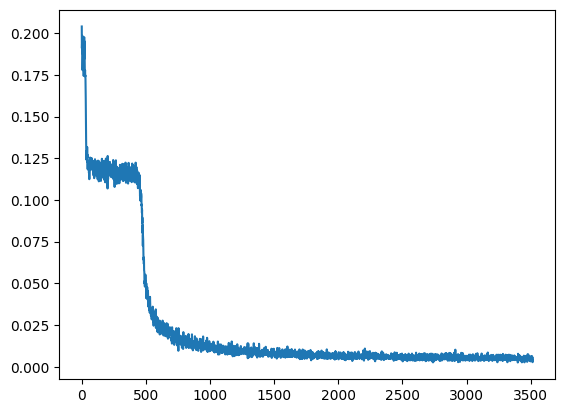

--------------------------------------

Starting main process


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 51.96it/s]


Epoch: 1: avg_loss: 0.001920611606639385
Test IDs: 48       | PSNR:  28.797 | MSE : 0.001
Test IDs: 40       | PSNR:  30.339 | MSE : 0.001
Test IDs: 40       | PSNR:  30.339 | MSE : 0.001
Test IDs: 42       | PSNR:  29.189 | MSE : 0.001
Test IDs: 63       | PSNR:  28.640 | MSE : 0.001


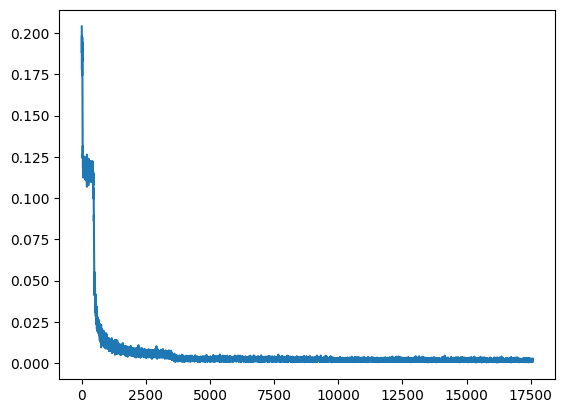

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:33<00:00, 51.49it/s]


Epoch: 2: avg_loss: 0.0013588379422438848
Test IDs: 48       | PSNR:  29.215 | MSE : 0.001
Test IDs: 40       | PSNR:  30.868 | MSE : 0.001
Test IDs: 40       | PSNR:  30.868 | MSE : 0.001
Test IDs: 42       | PSNR:  30.256 | MSE : 0.001
Test IDs: 63       | PSNR:  29.884 | MSE : 0.001


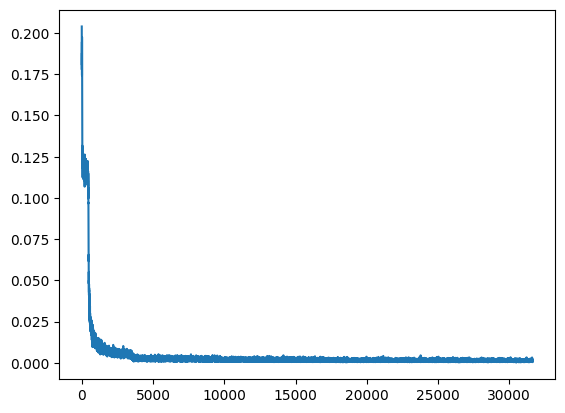

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:33<00:00, 51.50it/s]


Epoch: 3: avg_loss: 0.0011861317506074275
Test IDs: 48       | PSNR:  30.122 | MSE : 0.001
Test IDs: 40       | PSNR:  31.557 | MSE : 0.001
Test IDs: 40       | PSNR:  31.557 | MSE : 0.001
Test IDs: 42       | PSNR:  30.729 | MSE : 0.001
Test IDs: 63       | PSNR:  30.350 | MSE : 0.001


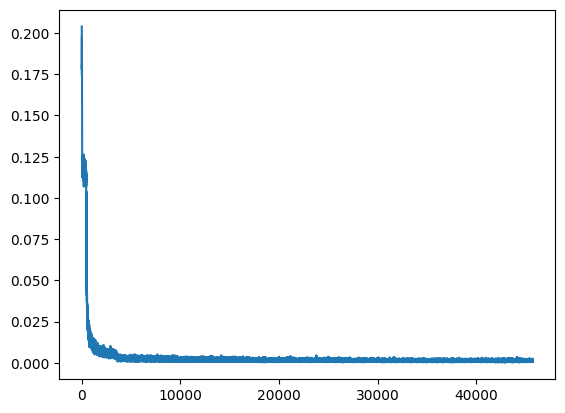

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 51.90it/s]


Epoch: 4: avg_loss: 0.001084037043314438
Test IDs: 48       | PSNR:  30.477 | MSE : 0.001
Test IDs: 40       | PSNR:  31.540 | MSE : 0.001
Test IDs: 40       | PSNR:  31.540 | MSE : 0.001
Test IDs: 42       | PSNR:  30.710 | MSE : 0.001
Test IDs: 63       | PSNR:  30.108 | MSE : 0.001


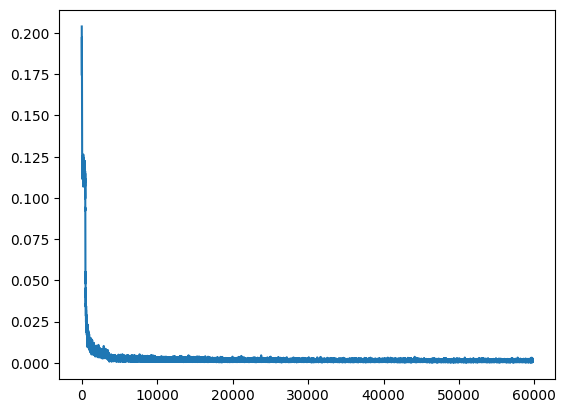

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:29<00:00, 52.20it/s]


Epoch: 5: avg_loss: 0.0010279192941687473
Test IDs: 48       | PSNR:  31.250 | MSE : 0.001
Test IDs: 40       | PSNR:  32.028 | MSE : 0.001
Test IDs: 40       | PSNR:  32.028 | MSE : 0.001
Test IDs: 42       | PSNR:  31.521 | MSE : 0.001
Test IDs: 63       | PSNR:  30.861 | MSE : 0.001


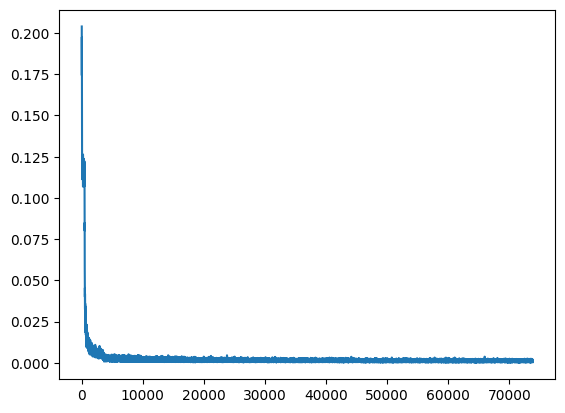

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:31<00:00, 51.86it/s]


Epoch: 6: avg_loss: 0.0009882658228235626
Test IDs: 48       | PSNR:  30.882 | MSE : 0.001
Test IDs: 40       | PSNR:  32.265 | MSE : 0.001
Test IDs: 40       | PSNR:  32.265 | MSE : 0.001
Test IDs: 42       | PSNR:  31.588 | MSE : 0.001
Test IDs: 63       | PSNR:  30.866 | MSE : 0.001


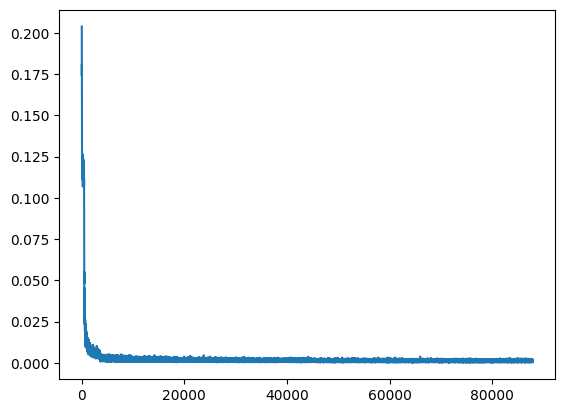

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 52.04it/s]


Epoch: 7: avg_loss: 0.0009532060490057549
Test IDs: 48       | PSNR:  31.293 | MSE : 0.001
Test IDs: 40       | PSNR:  32.334 | MSE : 0.001
Test IDs: 40       | PSNR:  32.334 | MSE : 0.001
Test IDs: 42       | PSNR:  31.681 | MSE : 0.001
Test IDs: 63       | PSNR:  31.073 | MSE : 0.001


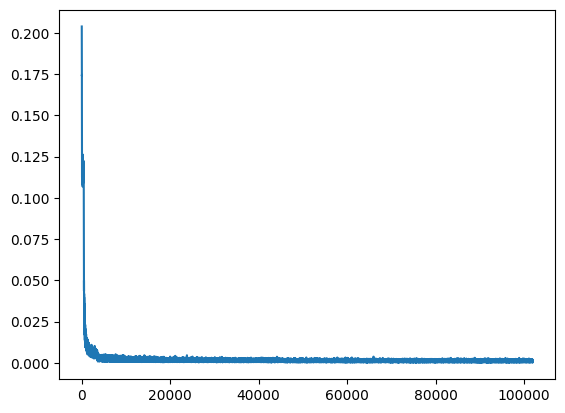

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 52.07it/s]


Epoch: 8: avg_loss: 0.0009283193100268492
Test IDs: 48       | PSNR:  31.363 | MSE : 0.001
Test IDs: 40       | PSNR:  32.608 | MSE : 0.001
Test IDs: 40       | PSNR:  32.608 | MSE : 0.001
Test IDs: 42       | PSNR:  31.712 | MSE : 0.001
Test IDs: 63       | PSNR:  30.989 | MSE : 0.001


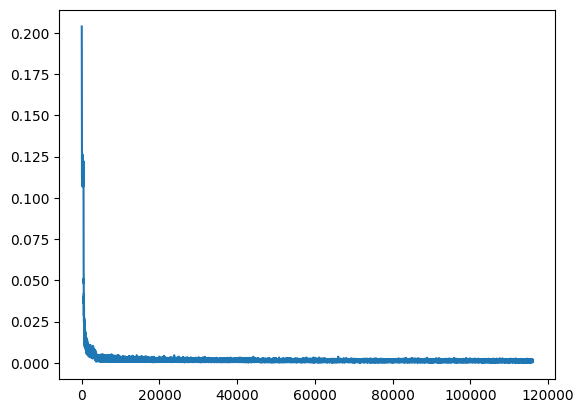

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:25<00:00, 52.87it/s]


Epoch: 9: avg_loss: 0.000911336360286192
Test IDs: 48       | PSNR:  31.335 | MSE : 0.001
Test IDs: 40       | PSNR:  32.490 | MSE : 0.001
Test IDs: 40       | PSNR:  32.490 | MSE : 0.001
Test IDs: 42       | PSNR:  31.819 | MSE : 0.001
Test IDs: 63       | PSNR:  31.230 | MSE : 0.001


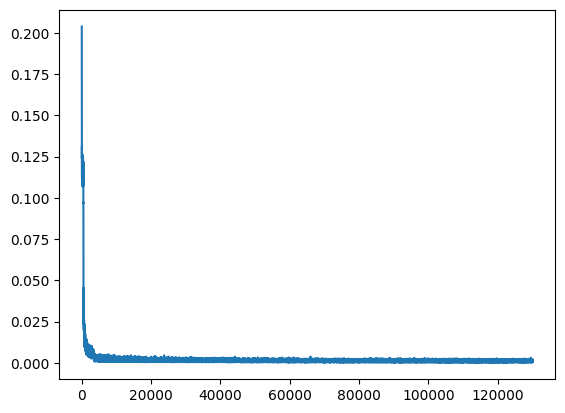

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:23<00:00, 53.29it/s]


Epoch: 10: avg_loss: 0.000896224512850265
Test IDs: 48       | PSNR:  31.576 | MSE : 0.001
Test IDs: 40       | PSNR:  32.644 | MSE : 0.001
Test IDs: 40       | PSNR:  32.644 | MSE : 0.001
Test IDs: 42       | PSNR:  31.932 | MSE : 0.001
Test IDs: 63       | PSNR:  31.230 | MSE : 0.001


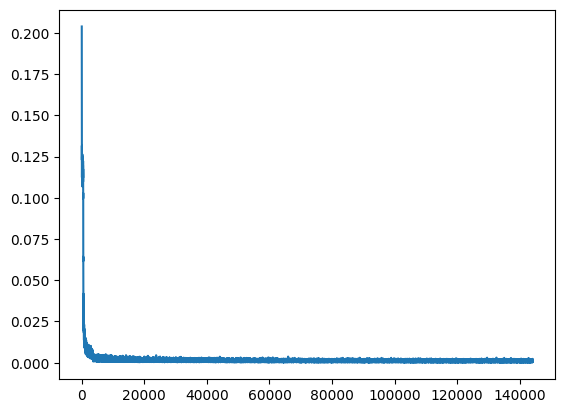

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:29<00:00, 52.27it/s]


Epoch: 11: avg_loss: 0.0008834379426870338
Test IDs: 48       | PSNR:  31.638 | MSE : 0.001
Test IDs: 40       | PSNR:  32.467 | MSE : 0.001
Test IDs: 40       | PSNR:  32.467 | MSE : 0.001
Test IDs: 42       | PSNR:  32.156 | MSE : 0.001
Test IDs: 63       | PSNR:  31.476 | MSE : 0.001


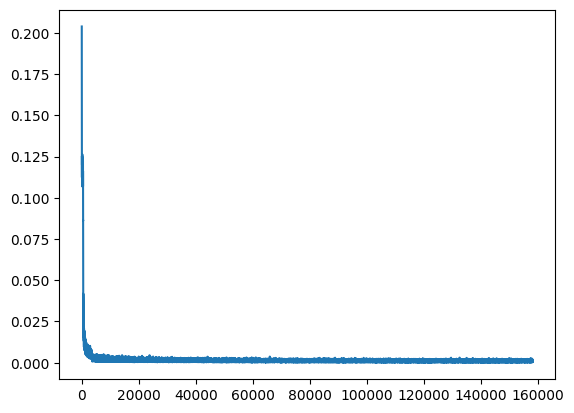

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 51.96it/s]


Epoch: 12: avg_loss: 0.0008742154165647195
Test IDs: 48       | PSNR:  31.805 | MSE : 0.001
Test IDs: 40       | PSNR:  32.528 | MSE : 0.001
Test IDs: 40       | PSNR:  32.528 | MSE : 0.001
Test IDs: 42       | PSNR:  32.260 | MSE : 0.001
Test IDs: 63       | PSNR:  31.520 | MSE : 0.001


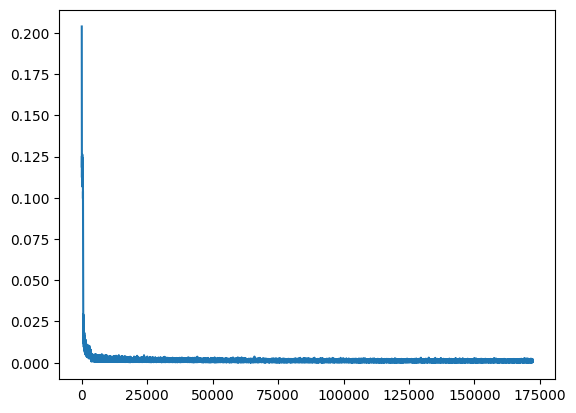

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:32<00:00, 51.69it/s]


Epoch: 13: avg_loss: 0.0008681555223903597
Test IDs: 48       | PSNR:  31.809 | MSE : 0.001
Test IDs: 40       | PSNR:  32.560 | MSE : 0.001
Test IDs: 40       | PSNR:  32.560 | MSE : 0.001
Test IDs: 42       | PSNR:  32.081 | MSE : 0.001
Test IDs: 63       | PSNR:  31.274 | MSE : 0.001


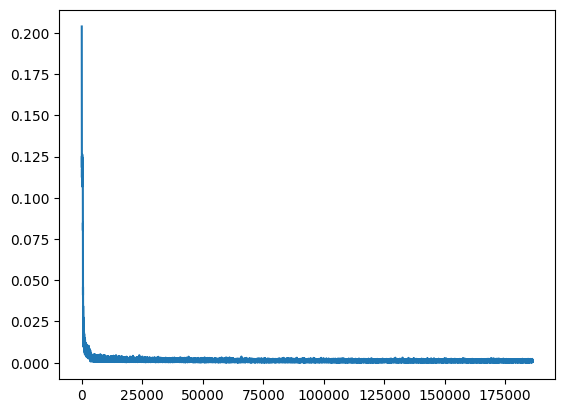

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:32<00:00, 51.57it/s]


Epoch: 14: avg_loss: 0.0008615187070276872
Test IDs: 48       | PSNR:  31.693 | MSE : 0.001
Test IDs: 40       | PSNR:  32.666 | MSE : 0.001
Test IDs: 40       | PSNR:  32.666 | MSE : 0.001
Test IDs: 42       | PSNR:  32.104 | MSE : 0.001
Test IDs: 63       | PSNR:  31.346 | MSE : 0.001


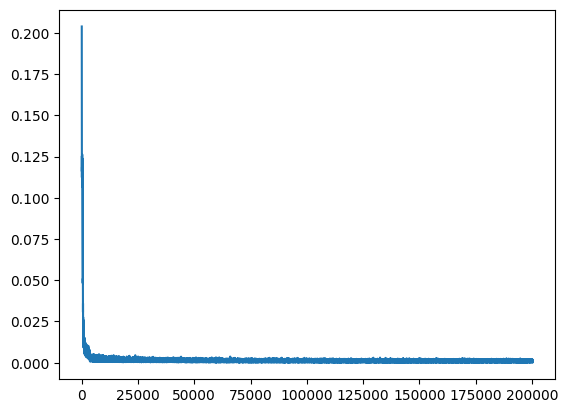

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:31<00:00, 51.76it/s]


Epoch: 15: avg_loss: 0.0008559706127392083
Test IDs: 48       | PSNR:  31.621 | MSE : 0.001
Test IDs: 40       | PSNR:  32.600 | MSE : 0.001
Test IDs: 40       | PSNR:  32.600 | MSE : 0.001
Test IDs: 42       | PSNR:  32.055 | MSE : 0.001
Test IDs: 63       | PSNR:  31.212 | MSE : 0.001


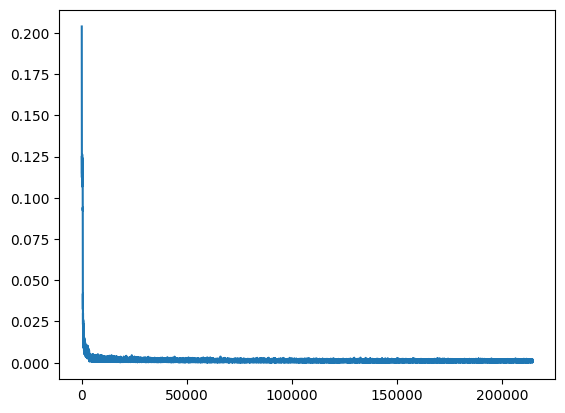

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:28<00:00, 52.41it/s]


Epoch: 16: avg_loss: 0.0008523867480522524
Test IDs: 48       | PSNR:  31.641 | MSE : 0.001
Test IDs: 40       | PSNR:  32.626 | MSE : 0.001
Test IDs: 40       | PSNR:  32.626 | MSE : 0.001
Test IDs: 42       | PSNR:  32.161 | MSE : 0.001
Test IDs: 63       | PSNR:  31.401 | MSE : 0.001


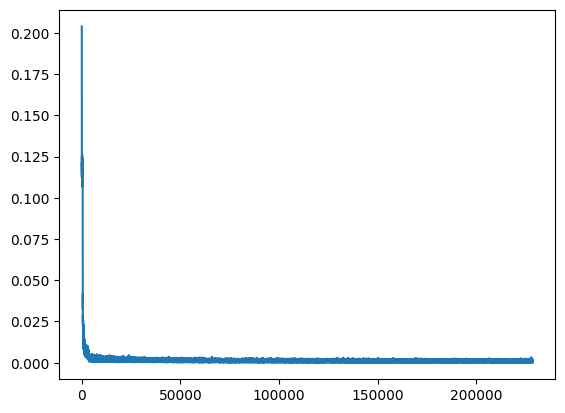

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:29<00:00, 52.25it/s]


Epoch: 17: avg_loss: 0.0008462939773555386
Test IDs: 48       | PSNR:  31.706 | MSE : 0.001
Test IDs: 40       | PSNR:  32.650 | MSE : 0.001
Test IDs: 40       | PSNR:  32.650 | MSE : 0.001
Test IDs: 42       | PSNR:  32.225 | MSE : 0.001
Test IDs: 63       | PSNR:  31.489 | MSE : 0.001


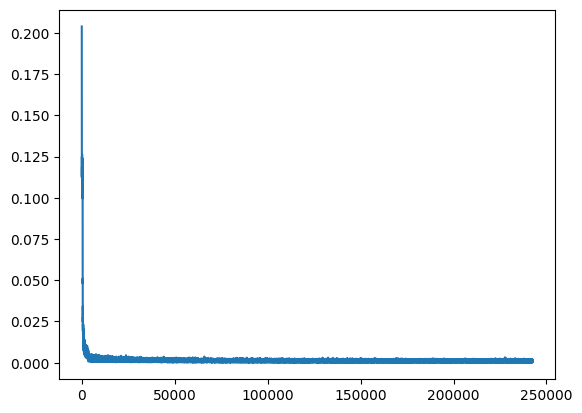

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:32<00:00, 51.64it/s]


Epoch: 18: avg_loss: 0.0008450353938671812
Test IDs: 48       | PSNR:  31.726 | MSE : 0.001
Test IDs: 40       | PSNR:  32.727 | MSE : 0.001
Test IDs: 40       | PSNR:  32.727 | MSE : 0.001
Test IDs: 42       | PSNR:  32.177 | MSE : 0.001
Test IDs: 63       | PSNR:  31.403 | MSE : 0.001


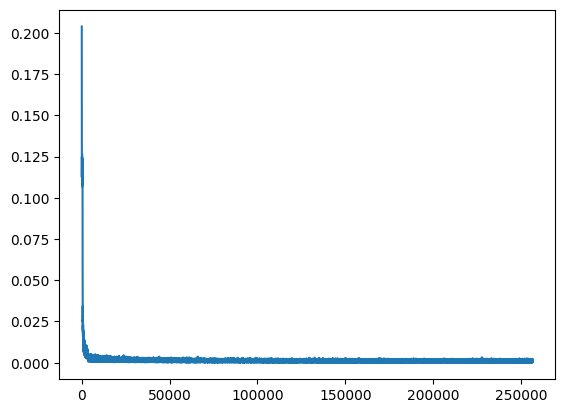

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:32<00:00, 51.60it/s]


Epoch: 19: avg_loss: 0.0008400672960938417
Test IDs: 48       | PSNR:  31.754 | MSE : 0.001
Test IDs: 40       | PSNR:  32.704 | MSE : 0.001
Test IDs: 40       | PSNR:  32.704 | MSE : 0.001
Test IDs: 42       | PSNR:  32.248 | MSE : 0.001
Test IDs: 63       | PSNR:  31.447 | MSE : 0.001


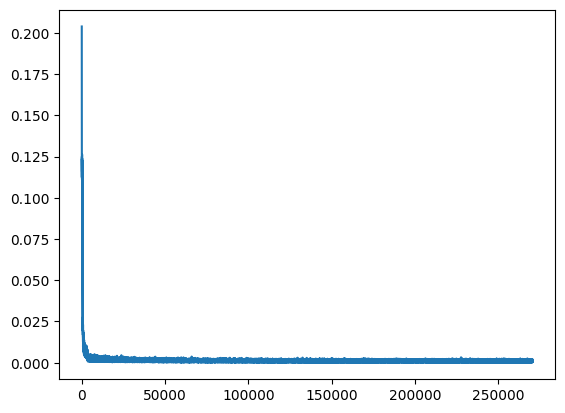

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 52.07it/s]


Epoch: 20: avg_loss: 0.0008416232862924521
Test IDs: 48       | PSNR:  31.802 | MSE : 0.001
Test IDs: 40       | PSNR:  32.647 | MSE : 0.001
Test IDs: 40       | PSNR:  32.647 | MSE : 0.001
Test IDs: 42       | PSNR:  32.204 | MSE : 0.001
Test IDs: 63       | PSNR:  31.405 | MSE : 0.001


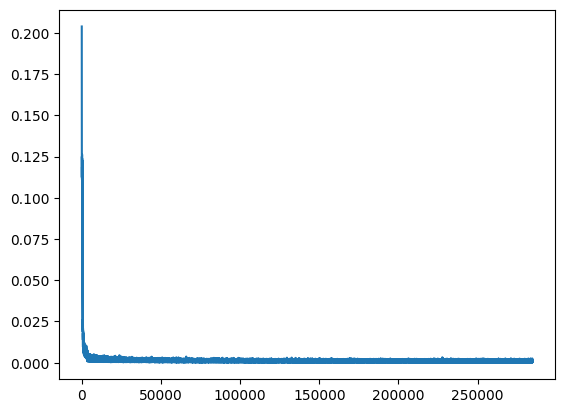

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:25<00:00, 53.04it/s]


Epoch: 21: avg_loss: 0.0008366197814504676
Test IDs: 48       | PSNR:  31.780 | MSE : 0.001
Test IDs: 40       | PSNR:  32.728 | MSE : 0.001
Test IDs: 40       | PSNR:  32.728 | MSE : 0.001
Test IDs: 42       | PSNR:  32.223 | MSE : 0.001
Test IDs: 63       | PSNR:  31.420 | MSE : 0.001


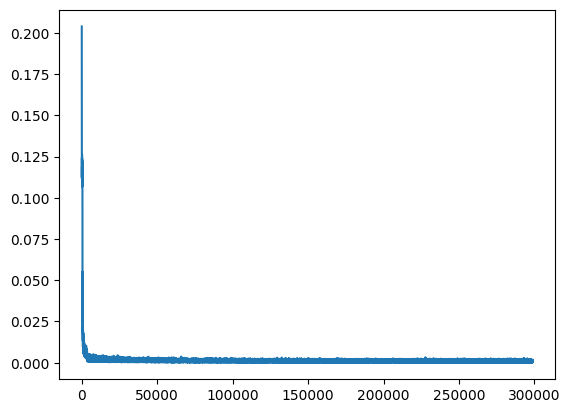

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:31<00:00, 51.77it/s]


Epoch: 22: avg_loss: 0.0008368197717699541
Test IDs: 48       | PSNR:  31.781 | MSE : 0.001
Test IDs: 40       | PSNR:  32.709 | MSE : 0.001
Test IDs: 40       | PSNR:  32.709 | MSE : 0.001
Test IDs: 42       | PSNR:  32.221 | MSE : 0.001
Test IDs: 63       | PSNR:  31.425 | MSE : 0.001


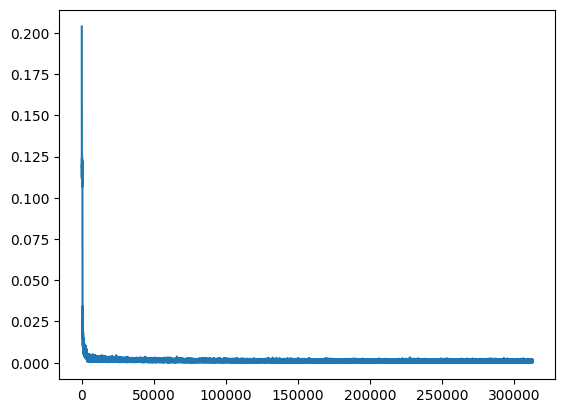

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:27<00:00, 52.58it/s]


Epoch: 23: avg_loss: 0.0008357379201300029
Test IDs: 48       | PSNR:  31.755 | MSE : 0.001
Test IDs: 40       | PSNR:  32.682 | MSE : 0.001
Test IDs: 40       | PSNR:  32.682 | MSE : 0.001
Test IDs: 42       | PSNR:  32.238 | MSE : 0.001
Test IDs: 63       | PSNR:  31.426 | MSE : 0.001


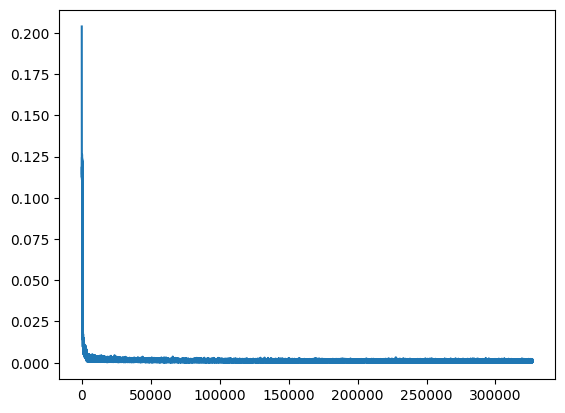

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:26<00:00, 52.79it/s]


Epoch: 24: avg_loss: 0.0008359019025532394
Test IDs: 48       | PSNR:  31.819 | MSE : 0.001
Test IDs: 40       | PSNR:  32.694 | MSE : 0.001
Test IDs: 40       | PSNR:  32.694 | MSE : 0.001
Test IDs: 42       | PSNR:  32.282 | MSE : 0.001
Test IDs: 63       | PSNR:  31.458 | MSE : 0.001


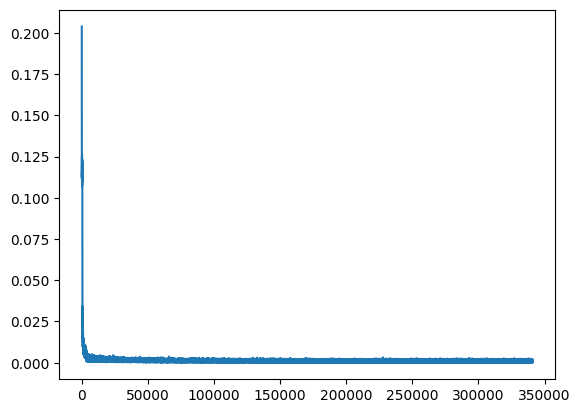

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:30<00:00, 51.99it/s]


Epoch: 25: avg_loss: 0.0008352549923697607
Test IDs: 48       | PSNR:  31.783 | MSE : 0.001
Test IDs: 40       | PSNR:  32.749 | MSE : 0.001
Test IDs: 40       | PSNR:  32.749 | MSE : 0.001
Test IDs: 42       | PSNR:  32.258 | MSE : 0.001
Test IDs: 63       | PSNR:  31.438 | MSE : 0.001


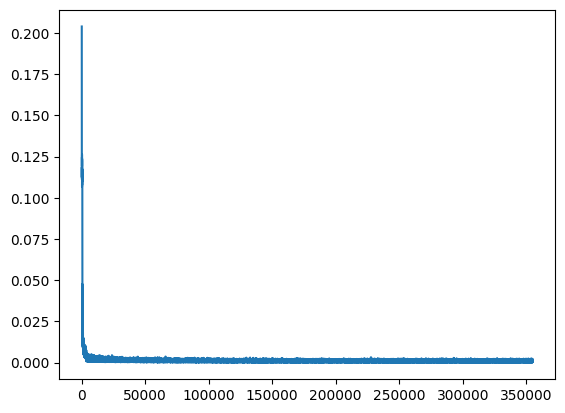

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:27<00:00, 52.53it/s]


Epoch: 26: avg_loss: 0.0008345666657136913
Test IDs: 48       | PSNR:  31.802 | MSE : 0.001
Test IDs: 40       | PSNR:  32.738 | MSE : 0.001
Test IDs: 40       | PSNR:  32.738 | MSE : 0.001
Test IDs: 42       | PSNR:  32.268 | MSE : 0.001
Test IDs: 63       | PSNR:  31.452 | MSE : 0.001


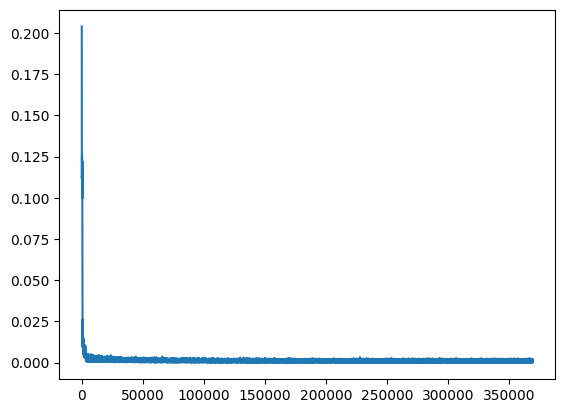

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:29<00:00, 52.09it/s]


Epoch: 27: avg_loss: 0.0008325556790256375
Test IDs: 48       | PSNR:  31.791 | MSE : 0.001
Test IDs: 40       | PSNR:  32.702 | MSE : 0.001
Test IDs: 40       | PSNR:  32.702 | MSE : 0.001
Test IDs: 42       | PSNR:  32.247 | MSE : 0.001
Test IDs: 63       | PSNR:  31.434 | MSE : 0.001


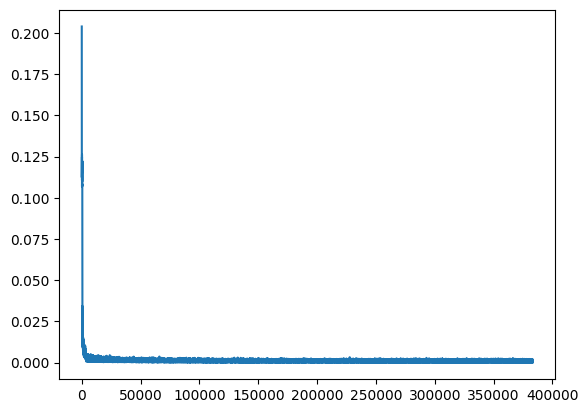

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:28<00:00, 52.30it/s]


Epoch: 28: avg_loss: 0.0008349044129478112
Test IDs: 48       | PSNR:  31.754 | MSE : 0.001
Test IDs: 40       | PSNR:  32.712 | MSE : 0.001
Test IDs: 40       | PSNR:  32.712 | MSE : 0.001
Test IDs: 42       | PSNR:  32.227 | MSE : 0.001
Test IDs: 63       | PSNR:  31.411 | MSE : 0.001


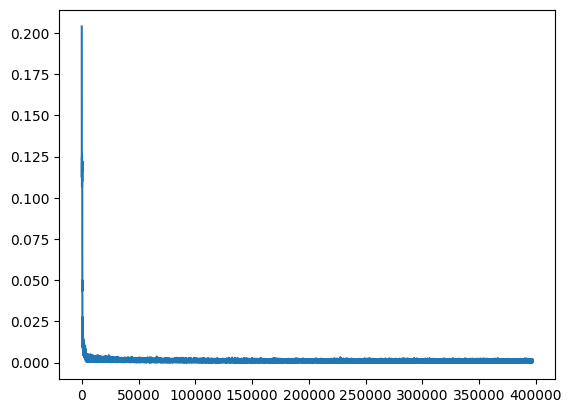

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:28<00:00, 52.28it/s]


Epoch: 29: avg_loss: 0.0008333495888260492
Test IDs: 48       | PSNR:  31.779 | MSE : 0.001
Test IDs: 40       | PSNR:  32.706 | MSE : 0.001
Test IDs: 40       | PSNR:  32.706 | MSE : 0.001
Test IDs: 42       | PSNR:  32.247 | MSE : 0.001
Test IDs: 63       | PSNR:  31.436 | MSE : 0.001


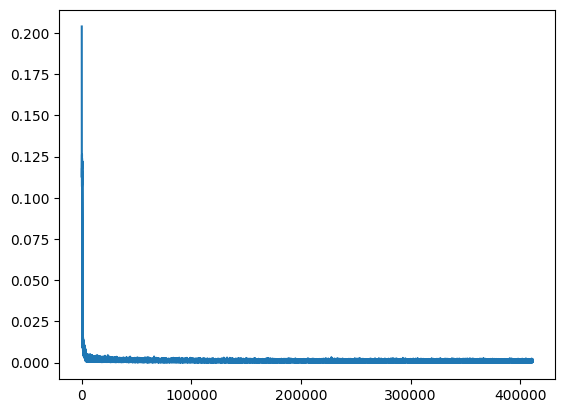

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14063/14063 [04:29<00:00, 52.11it/s]


Epoch: 30: avg_loss: 0.0008318423338850591
Test IDs: 48       | PSNR:  31.789 | MSE : 0.001
Test IDs: 40       | PSNR:  32.702 | MSE : 0.001
Test IDs: 40       | PSNR:  32.702 | MSE : 0.001
Test IDs: 42       | PSNR:  32.258 | MSE : 0.001
Test IDs: 63       | PSNR:  31.448 | MSE : 0.001


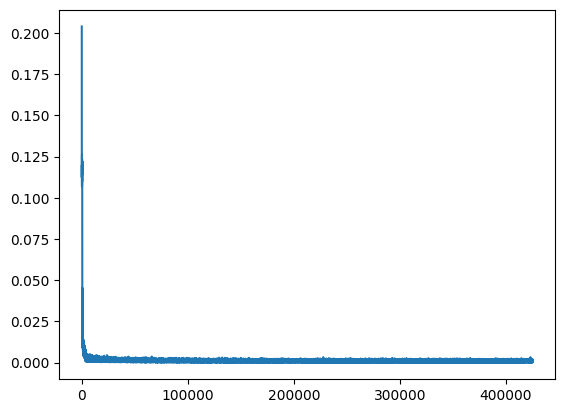

In [14]:


loss_history = []

model = FourierNerf(NF_feats=NF_feats, B_scale=B_scale, hidden_dim=hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)

## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/fourier_nerf", obj)


################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse

def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for tid in test_ids:
            o_, d_ = create_rays(imgs[tid], poses[tid], intrinsics[tid])
            im  = imgs[tid]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=128,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {tid}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            imdir = osp.join(session.sess_dir, f"epoch_{epoch}")
            if not osp.exists(imdir):
                os.makedirs(imdir)
            impath = osp.join(imdir, f"epoch-{epoch}--image-{tid}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))
               
############################## WARM UP TRAINING : 
##################Train on center part of image (Needed for synthetic dataset  ####################

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, device=device, 
                    directional_input=directional_input,white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader_warmup)}")
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-warmup.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, "warmup")
    plt.plot(loss_history)
    plt.show()

    
####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, directional_input=False, device=device, white_bgr=True)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader)}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    plt.plot(loss_history)
    plt.show()
    


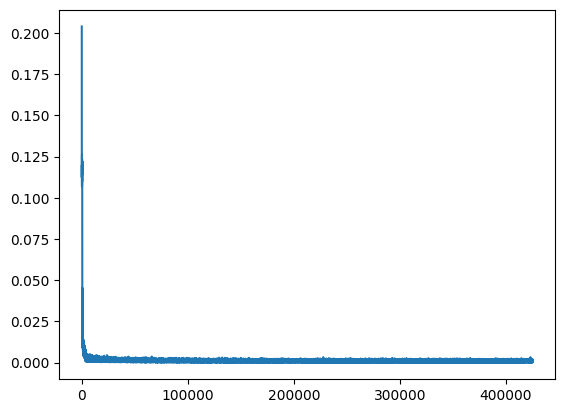

In [15]:
plt.plot(loss_history)

# Training on LLFF Dataset

## Load dataset

We will load the LLFF dataset which is hosted here: [LLFF Dataset](https://github.com/Fyusion/LLFF) <br>
From this, we will focus on nerf images.

In [9]:
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

In [38]:
root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "horns"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"

data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
imgs.shape, poses.shape, imats.shape, metas.shape

((62, 378, 504, 3), (62, 4, 4), (62, 4, 4), (62, 2))

In [39]:
poses[0]

array([[-0.02398401,  0.99157602, -0.12728617, -4.84368732],
       [ 0.99576942,  0.01239796, -0.09104697, -2.96135971],
       [-0.0887019 , -0.12893135, -0.98767843, -1.72860791],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## Training Loop

In [49]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

from src.utils.render import render, batchify_image_and_render

In [50]:
root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "horns"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"


In [51]:
data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
imgs.shape, poses.shape, imats.shape, metas.shape

((62, 378, 504, 3), (62, 4, 4), (62, 4, 4), (62, 2))

In [26]:
poses[0]

array([[-0.02398401,  0.99157602, -0.12728617, -4.84368732],
       [ 0.99576942,  0.01239796, -0.09104697, -2.96135971],
       [-0.0887019 , -0.12893135, -0.98767843, -1.72860791],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [44]:
batch_size = 1024
dataset_warmup = LLFFDataset(imgs, poses, imats, metas, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = LLFFDataset(imgs, poses, imats, metas, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 57.06it/s]


Center region: Width 126: 378,  Height: 94: 283
Final shapes: O:(2452968, 3), D:(2452968, 3), Imgs:(2452968, 3)
Final concatenated shape: torch.Size([2452968, 9])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 61.37it/s]


Final shapes: O:(62, 190512, 3), D:(62, 190512, 3), Imgs:(62, 378, 504, 3)
Final concatenated shape: torch.Size([11811744, 9])


In [52]:
num_epochs= 10
warmup_epochs = 1
tn = 3
tf = 7
num_bins = 100
lr = 1e-3

## Model Hyperparams
NF_feats=256
B_scale=6.05
hidden_dim = 128

loss_history = []

model = FourierNerf(NF_feats=NF_feats, B_scale=B_scale, hidden_dim=hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5, 10, 15], gamma=0.5)

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, device=device, directional_input=False,white_bgr=True)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader_warmup)}")

print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        # progress_bar = tqdm(dataloader, desc=f"Epoch {e+1}/{num_epochs}  | batch: {idx}")
        N = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render(model, o, d, tn, tf, num_bins, directional_input=False,device=device, white_bgr=True)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader)}")
    
        
    scheduler.step()
    torch.save(model.cpu(), f'model_nerf_{obj}-epoch{e+1}.pth')
    model.to(device)
    


Starting warm-up


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2396/2396 [01:15<00:00, 31.70it/s]


Epoch: 1: avg_loss: 0.017529716984584977
--------------------------------------

Starting main process


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:03<00:00, 31.74it/s]


Epoch: 1: avg_loss: 0.016160196711409773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:03<00:00, 31.74it/s]


Epoch: 2: avg_loss: 0.012653244386407324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [05:58<00:00, 32.14it/s]


Epoch: 3: avg_loss: 0.01167502446753293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [05:59<00:00, 32.06it/s]


Epoch: 4: avg_loss: 0.011091588401063262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:02<00:00, 31.83it/s]


Epoch: 5: avg_loss: 0.010685264825575476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:07<00:00, 31.42it/s]


Epoch: 6: avg_loss: 0.00952683508147473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:02<00:00, 31.84it/s]


Epoch: 7: avg_loss: 0.009330907161418215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [06:02<00:00, 31.79it/s]


Epoch: 8: avg_loss: 0.009219246385251683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [05:59<00:00, 32.09it/s]


Epoch: 9: avg_loss: 0.009132243005424015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11535/11535 [05:58<00:00, 32.19it/s]

Epoch: 10: avg_loss: 0.009052278575462001


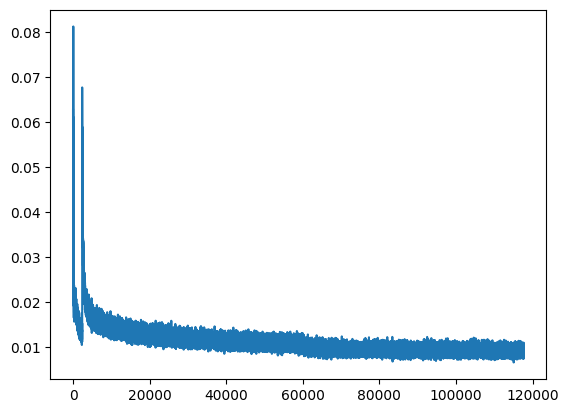

In [59]:
plt.plot(loss_history)

## Test on LLFF Dataset

In [54]:
NF_feats=256
B_scale=6.05
hidden_dim = 128
model = FourierNerf(NF_feats=NF_feats, B_scale=B_scale, hidden_dim=hidden_dim, device=device)
modelpath = "../model_checkpoints/nerf_llff_horns/model_nerf_horns-epoch10.pth"
model = torch.load(modelpath).to(device)

In [56]:
from src.utils.render import batchify_image_and_render
from src.utils.dataset.llff_dataset import read_files, create_rays, LLFFDataset

root = "/home/ayush/Downloads/datasets/nerf_llff_data"
obj = "horns"
resolution = "8" # reduced by factor of 8
poses_file = "poses_bounds.npy"

data = read_files(root, obj, resolution, poses_file)
imgs, poses, imats, metas = data[obj]
imgs.shape, poses.shape, imats.shape, metas.shape

((62, 378, 504, 3), (62, 4, 4), (62, 4, 4), (62, 2))

In [57]:
# small batch experiment

N = 5
otest, dtest = [], []
for i in range(N):
    o_test, d_test = create_rays(imgs[i], poses[i], imats[i], metas[i])
    otest.append(o_test)
    dtest.append(d_test)
otest = np.array(otest)
dtest = np.array(dtest)
otest.shape, dtest.shape

((5, 190512, 3), (5, 190512, 3))

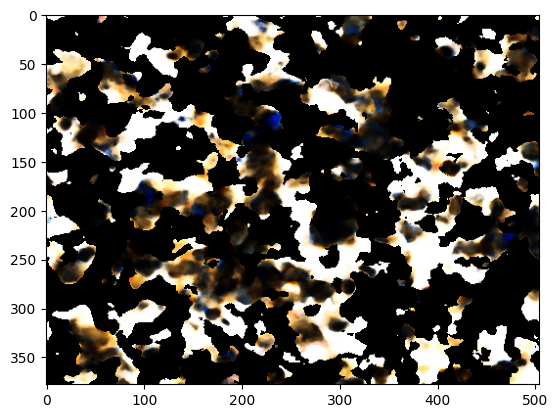

In [58]:
torch.cuda.empty_cache()

img_idx = 0
tn = 3
tf = 7
im = imgs[img_idx]
H, W = metas[img_idx]

with torch.no_grad():
    Ax = batchify_image_and_render(model=model,
                                   rays_o=otest[img_idx],
                                   rays_d=dtest[img_idx],
                                   tn=tn,
                                   tf=tf,
                                   num_bins=100,
                                   reduction_factor=16,
                                   device=device,
                                   directional_input=False,
                                   white_bgr=False)

plt.imshow(Ax.reshape(H, W, 3))